In [4]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import rc
from scipy.stats import pearsonr
from optimalEmbedding_sampling import run_optEmbedding_sampling
from GCCM_sampling import run_GCCM_sampling
from matplotlib.legend_handler import HandlerLineCollection, HandlerTuple
from matplotlib.ticker import MaxNLocator
import matplotlib.gridspec as gridspec
from plot import get_mean, get_interval, make_Eplot, make_Lplot

%load_ext autoreload
%autoreload 2

In [5]:
# Set specific font sizes
plt.rcParams.update({
    'font.size': 12,          # Global font size
    'axes.titlesize': 11,     # Title font size
    'axes.labelsize': 11,     # X and Y axis labels font size
    'xtick.labelsize': 9,    # X-axis tick labels font size
    'ytick.labelsize': 9,    # Y-axis tick labels font size
    'legend.fontsize': 10,    # Legend font size
})
rc('font', **{'family': 'serif', 'serif': ['Computer Modern']})
rc('text', usetex=True)

In [6]:
def laplacian(Z):
    Ztop = Z[0:-2, 1:-1]
    Zleft = Z[1:-1, 0:-2]
    Zbottom = Z[2:, 1:-1]
    Zright = Z[1:-1, 2:]
    Zcenter = Z[1:-1, 1:-1]
    return (Ztop + Zleft + Zbottom + Zright - 4 * Zcenter) / dx**2

def show_patterns(U, ax=None):
    ax.imshow(U, cmap=plt.cm.viridis,
              interpolation='None')
           # extent=[-1, 1, -1, 1])
    ax.set_axis_off()

In [7]:
def initialize_buffer(shape, delay):
    # Initialize a buffer to store the delayed values of X
    return [np.zeros(shape) for _ in range(delay)]

def update_buffer(buffer, new_value):
    # Update the buffer with the new value and return the oldest value
    oldest_value = buffer.pop(0)
    buffer.append(new_value.copy())
    return oldest_value

In [8]:
def run_sim_delayed(X_in, Y_in, T, c, a1, a2, delay, saveas=False):
    X = X_in.copy()
    Y = Y_in.copy()
    
    dt = .001  # time step, 
    n = int(T / dt)  # number of iterations

    # Initialize the buffer for X with delay steps
    buffer = initialize_buffer(X.shape, delay)

    fig, axes = plt.subplots(2,8, figsize=(6.3, 2))
    step_plot = n // 8
    # We simulate the PDE with the finite difference
    # method.
    for i in range(n):
        # We compute the Laplacian of u and v.
        deltaX = laplacian(X)
        deltaY = laplacian(Y)
        
        # We take the values of u and v inside the grid.
        Xc = X[1:-1, 1:-1]
        Yc = Y[1:-1, 1:-1]
        # Get the delayed value of X from the buffer
        delayed_Xc = update_buffer(buffer, X)[1:-1, 1:-1]
        
        # We update the variables.
        X[1:-1, 1:-1], Y[1:-1, 1:-1] = \
            Xc + dt * (a1 * deltaX - Xc**2),\
            Yc + dt * (a2 * deltaY - Yc**2 + c * delayed_Xc * Yc)
        
        # Neumann conditions: derivatives at the edges
        # are null.
        for B in (X, Y):
            B[0, :] = B[1, :]
            B[-1, :] = B[-2, :]
            B[:, 0] = B[:, 1]
            B[:, -1] = B[:, -2]
    
        # We plot the state of the system at
        # 9 different times.
        if i % step_plot == 0 and i < 8 * step_plot:
            ax1 = axes[0, i // step_plot]
            ax2 = axes[1, i // step_plot]
            
            show_patterns(X, ax=ax1)
            ax1.set_title(f'${i * dt:.0f}$')
            show_patterns(Y, ax=ax2)
            #ax.set_title(f'Y $t={i * dt:.0f}$')
            if i // step_plot == 0:
                ax1.text(-0.25, 0.5, 'X', transform=ax1.transAxes, fontsize=11, horizontalalignment='center')
                ax2.text(-0.25, 0.5, 'Y', transform=ax2.transAxes, fontsize=11, horizontalalignment='center')
                
    plt.tight_layout()
    if saveas:
        plt.savefig('plots/diffusion_delayed/'+saveas, bbox_inches='tight')
    return X, Y

In [9]:
dims = np.arange(1,9)
lib_sizes = np.arange(10,101,30)
lib_size = 100

In [10]:
size = 100  # size of the 2D grid
dx = 2. / size  # space step
a1 = 2.8e-4 # 5e-3
a2 = 2.8e-4

In [17]:
np.random.seed(seed=3)
X_rand = np.random.rand(size, size)
Y_rand = np.random.rand(size, size)
top_row, left_col = 20, 20
bottom_row, right_col = 25, 30
X_rand[top_row:bottom_row+1, left_col:right_col+1] = 5

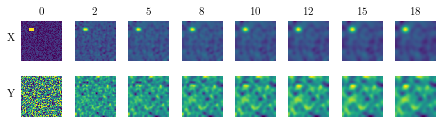

In [19]:
X, Y = run_sim_delayed(X_rand, Y_rand, T=20, c=0.1, a1=a1, a2=a2, delay=10)